Importing Libraries

1. Data Preperation

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, fowlkes_mallows_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import time

warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

1.1 Data Read

In [31]:
!wget "https://raw.githubusercontent.com/UW-MLGEO/MLGeo-dataset/refs/heads/main/data/Skyserver_SQL2_27_2018 6_51_39 PM.csv"

# Read the pandas dataframe from the csv file
df = pd.read_csv("Skyserver_SQL2_27_2018 6_51_39 PM.csv", skiprows=1)

# Save a copy of the dataframe
df_original = df.copy()

--2024-11-17 05:12:30--  https://raw.githubusercontent.com/UW-MLGEO/MLGeo-dataset/refs/heads/main/data/Skyserver_SQL2_27_2018%206_51_39%20PM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1377602 (1.3M) [text/plain]
Saving to: ‘Skyserver_SQL2_27_2018 6_51_39 PM.csv.4’

Skyserver_SQL2_27_2 100%[===================>]   1.31M  --.-KB/s    in 0.05s   

2024-11-17 05:12:30 (28.8 MB/s) - ‘Skyserver_SQL2_27_2018 6_51_39 PM.csv.4’ saved [1377602/1377602]



1.2 Data Cleaning

In [32]:
# Print column names to see what we're working with
print("Column names:")
print(df.columns.tolist())

# Rename the columns to meaningful names
df.columns = ['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 
              'run', 'rerun', 'camcol', 'field', 
              'specobjid', 'class', 'redshift',
              'plate', 'mjd', 'fiberid']

# Now drop the unnecessary columns
columns_to_drop = ['objid', 'specobjid', 'run', 'rerun', 'camcol', 'field']
df = df.drop(columns=columns_to_drop)

# Count objects in each class
class_counts = df['class'].value_counts()
print("\nObjects in each class:")
print(class_counts)

# Convert class labels to integers
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

Column names:
['1.23765E+18', '183.5313257', '0.08969303', '19.47406', '17.0424', '15.94699', '15.50342', '15.22531', '752', '301', '4', '267', '3.72236E+18', 'STAR', '-8.96E-06', '3306', '54922', '491']

Objects in each class:
class
GALAXY    4998
STAR      4151
QSO        850
Name: count, dtype: int64


1.3 Data correlations


Unique values in class column:
[2 0 1]


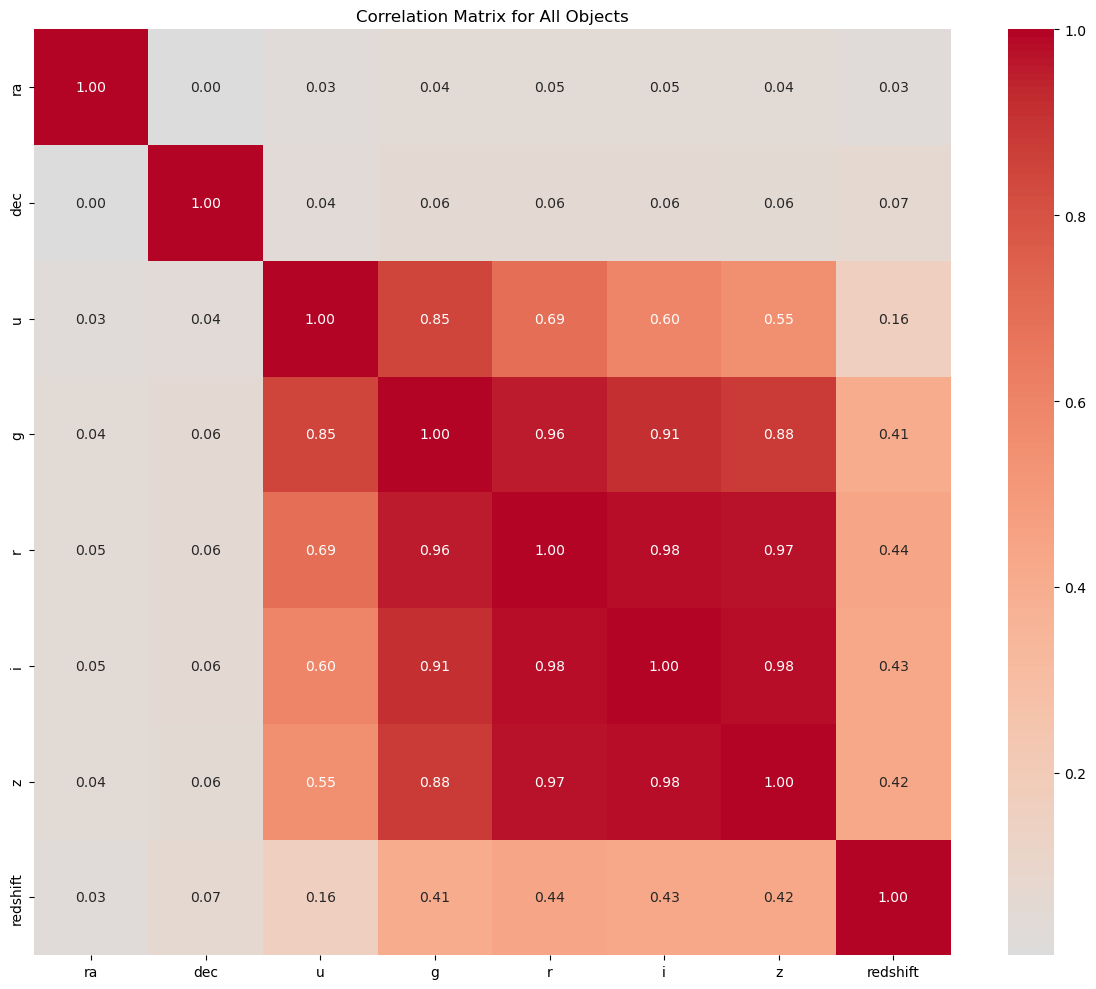

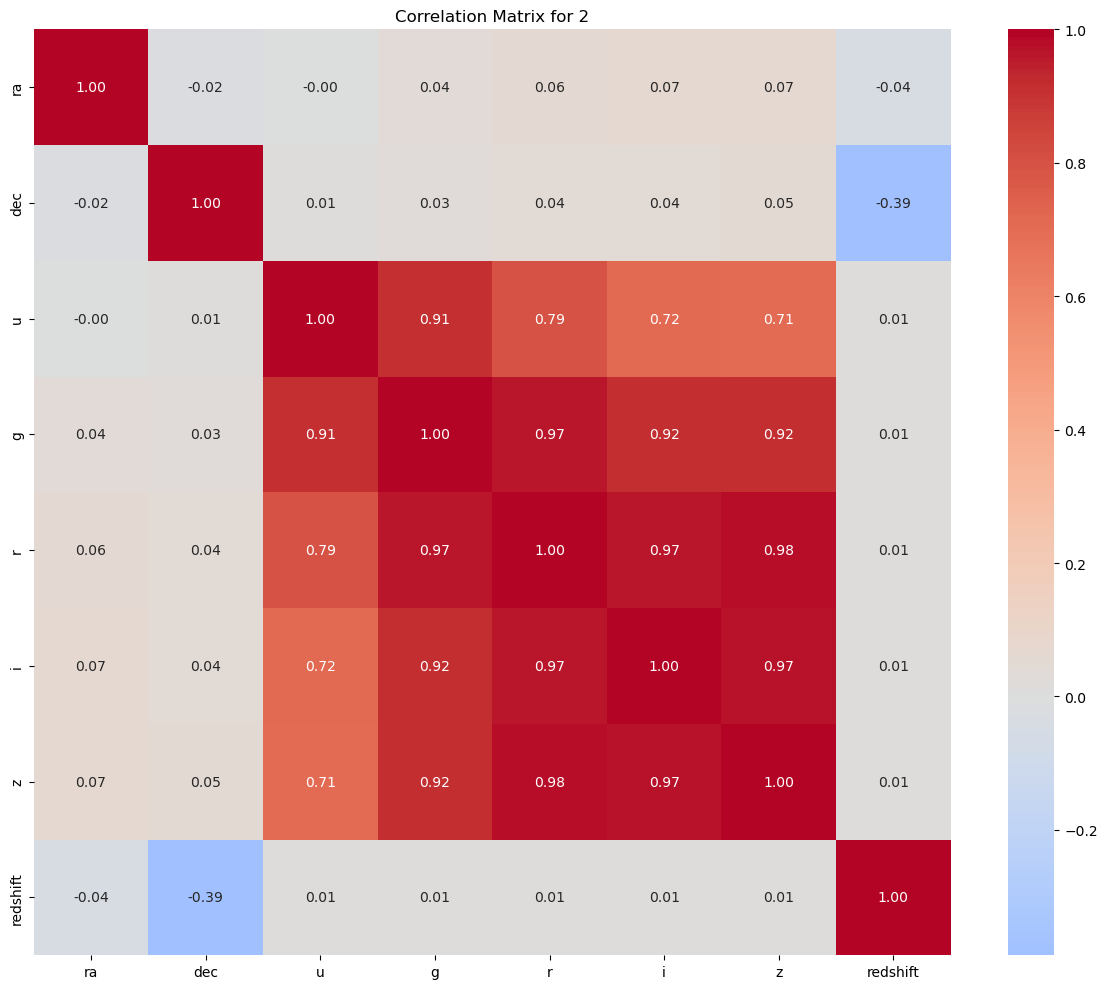

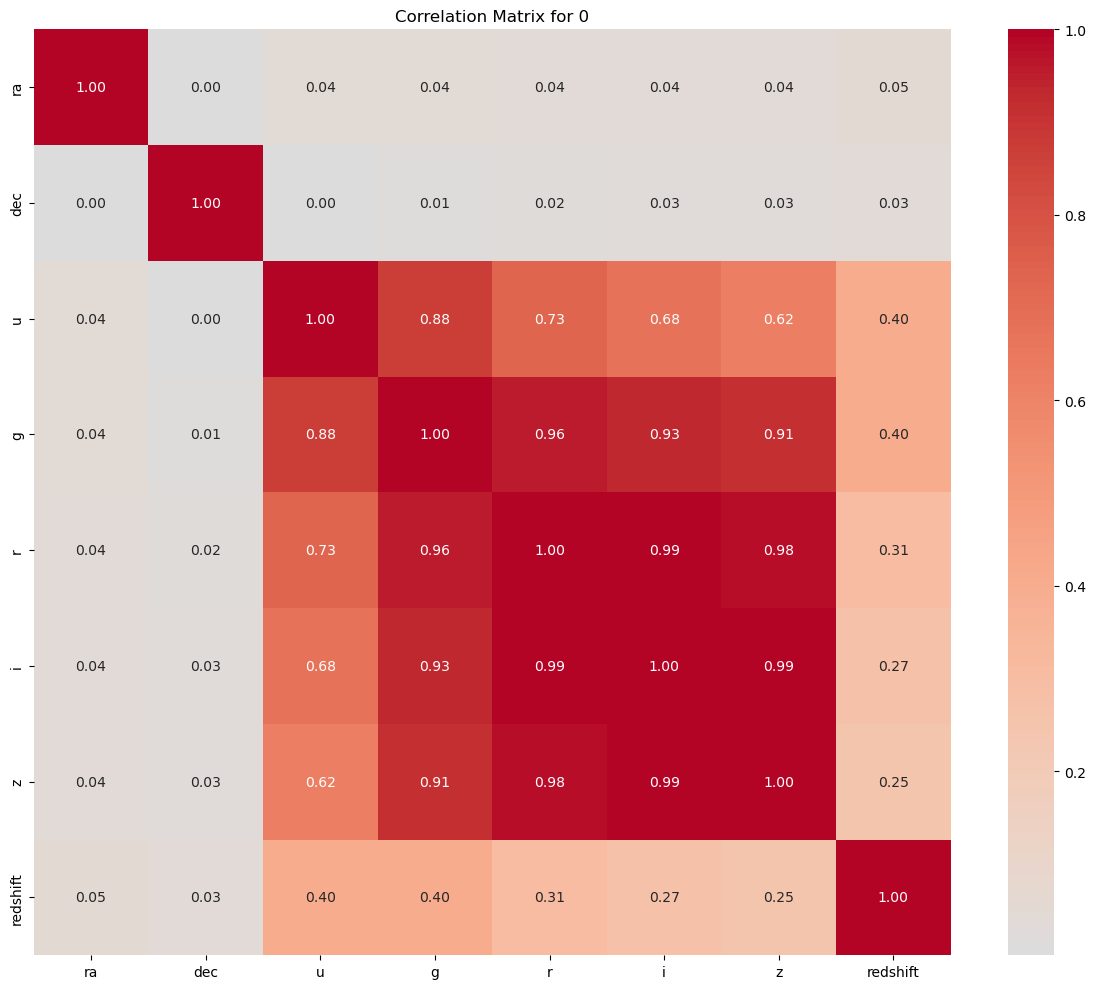

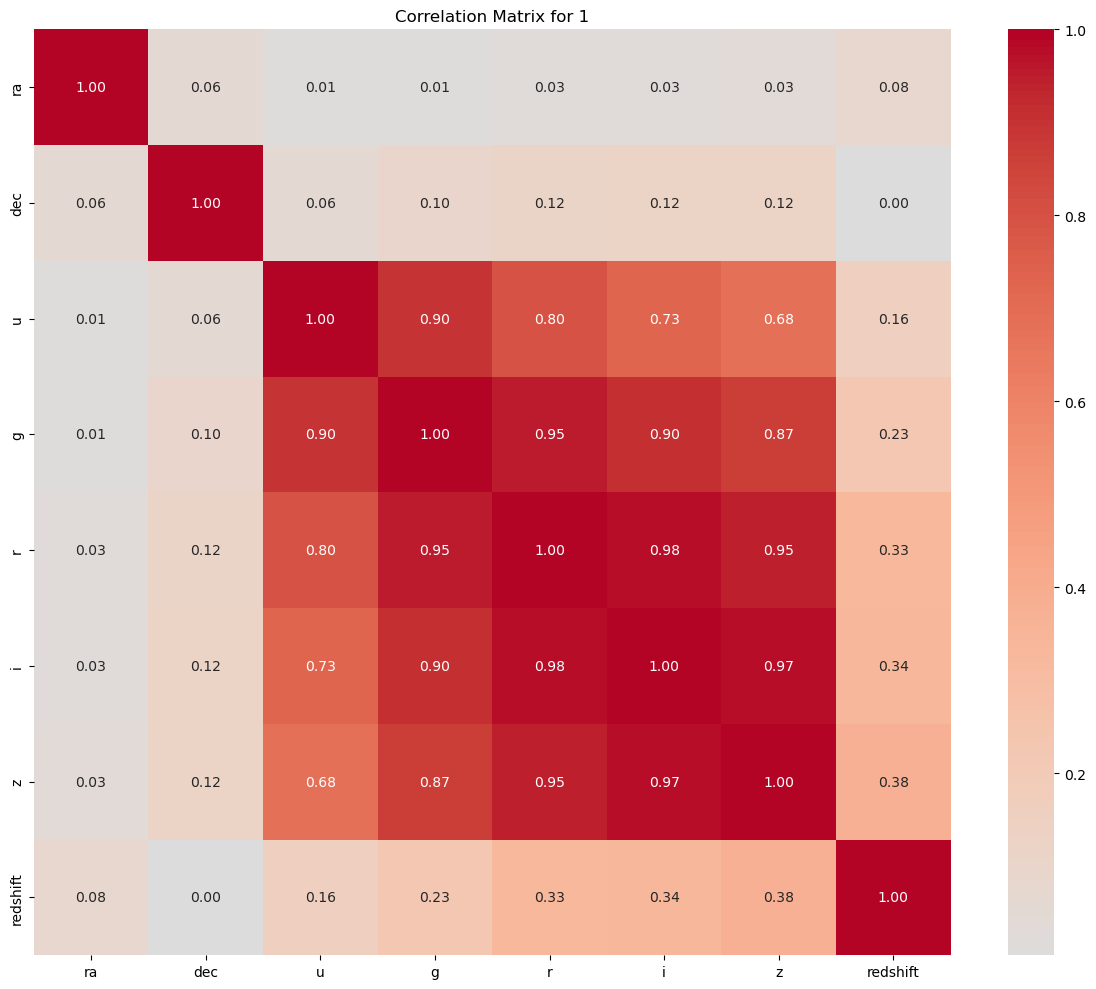

In [33]:
# First, let's see what unique values are in the 'class' column
print("Unique values in class column:")
print(df['class'].unique())

# Calculate correlation matrix for numerical columns
numerical_cols = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']
corr_matrix = df[numerical_cols].corr()

# Plot overall correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix for All Objects')
plt.tight_layout()
plt.show()

# Plot correlation matrix for each unique class
unique_classes = df['class'].unique()
for class_name in unique_classes:
    # Select data for current class
    class_df = df[df['class'] == class_name][numerical_cols]
    
    # Calculate correlation matrix for this class
    class_corr_matrix = class_df.corr()
    
    # Create plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(class_corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title(f'Correlation Matrix for {class_name}')
    plt.tight_layout()
    plt.show()

Comments on correlations:
The u, g, r, i, z features are highly correlated across all classes, which is expected as they represent different wavelength observations. The redshift feature shows some correlation with these features, especially for galaxies and quasars. Right ascension (ra) and declination (dec) show little correlation with other features, suggesting they are independent. There are slight differences in correlation patterns between the three celestial object types, which could be useful for classification.

1.5 Data exploration


1.5a Distributions of redshift

Unique class values: [2 0 1]

Sample of redshift values: 0   -0.000055
1    0.123111
2   -0.000111
3    0.000590
4    0.000315
Name: redshift, dtype: float64


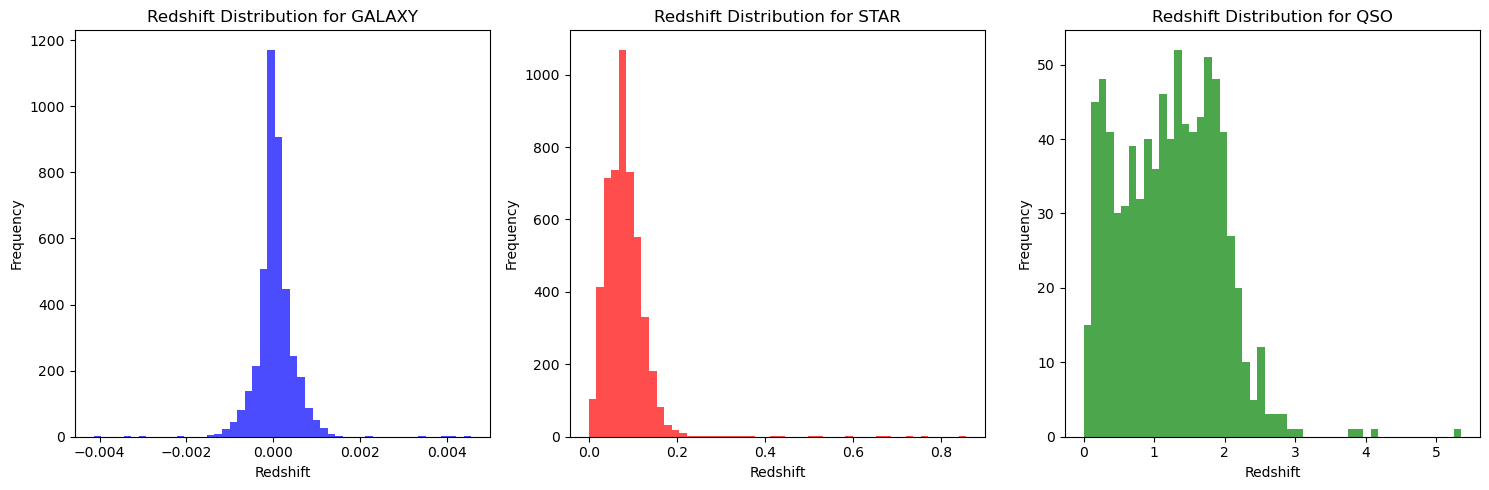


Number of objects in each class:
class
0    4998
2    4151
1     850
Name: count, dtype: int64

Redshift statistics for each class:

STAR:
count    4998.000000
mean        0.080325
std         0.046036
min        -0.000513
25%         0.051216
50%         0.077330
75%         0.101164
max         0.855881
Name: redshift, dtype: float64

QSO:
count    850.000000
mean       1.218366
std        0.697699
min        0.000461
25%        0.651192
50%        1.234131
75%        1.744641
max        5.353854
Name: redshift, dtype: float64

GALAXY:
count    4151.000000
mean        0.000043
std         0.000410
min        -0.004136
25%        -0.000133
50%         0.000024
75%         0.000218
max         0.004563
Name: redshift, dtype: float64


In [34]:
# First, let's check our data
print("Unique class values:", df['class'].unique())
print("\nSample of redshift values:", df['redshift'].head())

# Create histograms with numerical class labels
plt.figure(figsize=(15, 5))

# Plot for GALAXY (class 2)
plt.subplot(1, 3, 1)
galaxy_data = df[df['class'] == 2]['redshift']
plt.hist(galaxy_data, bins=50, color='blue', alpha=0.7)
plt.title('Redshift Distribution for GALAXY')
plt.xlabel('Redshift')
plt.ylabel('Frequency')

# Plot for STAR (class 0)
plt.subplot(1, 3, 2)
star_data = df[df['class'] == 0]['redshift']
plt.hist(star_data, bins=50, color='red', alpha=0.7)
plt.title('Redshift Distribution for STAR')
plt.xlabel('Redshift')
plt.ylabel('Frequency')

# Plot for QSO (class 1)
plt.subplot(1, 3, 3)
qso_data = df[df['class'] == 1]['redshift']
plt.hist(qso_data, bins=50, color='green', alpha=0.7)
plt.title('Redshift Distribution for QSO')
plt.xlabel('Redshift')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print statistics for verification
print("\nNumber of objects in each class:")
print(df['class'].value_counts())
print("\nRedshift statistics for each class:")
for class_num in [0, 1, 2]:  # STAR, QSO, GALAXY
    class_name = {0: 'STAR', 1: 'QSO', 2: 'GALAXY'}[class_num]
    print(f"\n{class_name}:")
    print(df[df['class'] == class_num]['redshift'].describe())

Description of redshift histograms:

**Stars (Red):**
- Sharp, narrow peak very close to zero redshift (around 0-0.2)
- Highest frequency reaches about 1000 objects
- Almost no stars beyond 0.2 redshift
- This tight distribution near zero confirms these are local objects within our galaxy

**Galaxies (Blue):**
- Symmetric distribution centered around zero
- Much narrower range than previously stated (-0.004 to 0.004)
- Peak frequency around 1200 objects
- Shows a clear Gaussian-like distribution
- The small redshift values suggest these are relatively nearby galaxies

**QSOs (Green):**
- Much broader distribution extending from 0 to 5+ redshift
- Multiple peaks between redshift 1-2
- Lower frequency counts (maximum around 50 objects)
- Several small outliers at very high redshifts (4-5)
- The large redshift range confirms these are the most distant objects in the sample

This distribution pattern clearly shows the hierarchical structure of our observable universe, from local stars to distant quasars, with each class occupying a distinct redshift range that reflects its typical distance from Earth.

1.5.b. Right ascension (ra) and declination (dec)


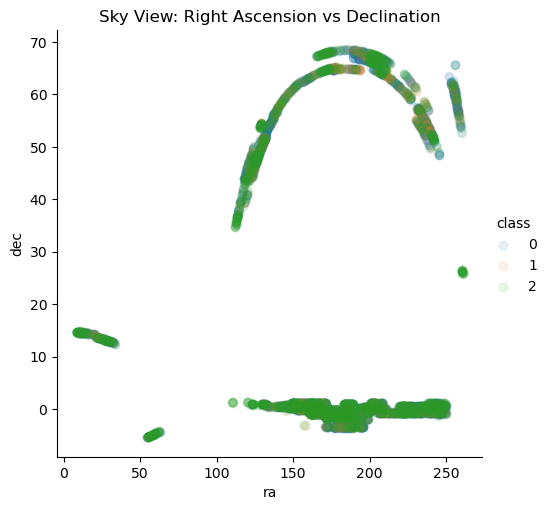

In [35]:
sns.lmplot(x='ra', y='dec', data=df, hue='class', fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('Sky View: Right Ascension vs Declination')
plt.show()

Comment on ra and dec:
There are no obvious differences in the distribution of ra and dec that would easily discriminate between the classes. The objects seem to be fairly uniformly distributed across the observed sky area.

1.5.c Filters - u,g,r,i,z


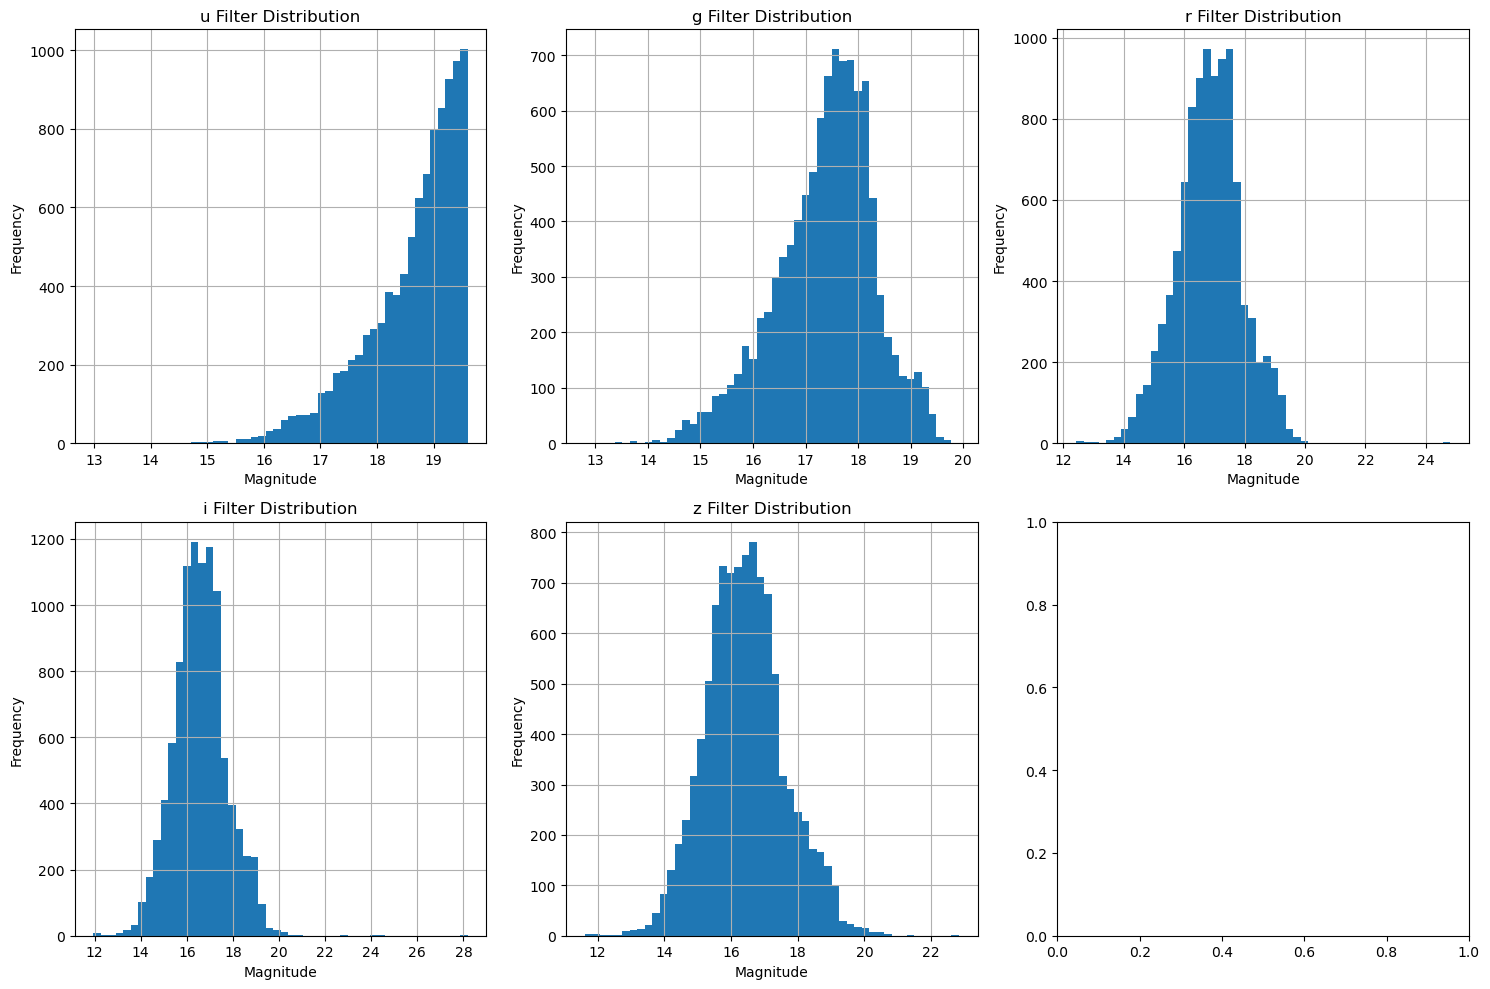

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, filter in enumerate(['u', 'g', 'r', 'i', 'z']):
    df[filter].hist(ax=axes[i], bins=50)
    axes[i].set_title(f'{filter} Filter Distribution')
    axes[i].set_xlabel('Magnitude')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Discussion on filter correlations:
The u, g, r, i, z filters are correlated because they represent observations of the same objects at different wavelengths. As celestial objects typically emit across a range of wavelengths, their brightness in different filters often follows similar patterns. The correlations are expected due to the continuous nature of the electromagnetic spectrum and the overlapping sensitivities of the filters.

1.6 Data Dimensionality Reduction


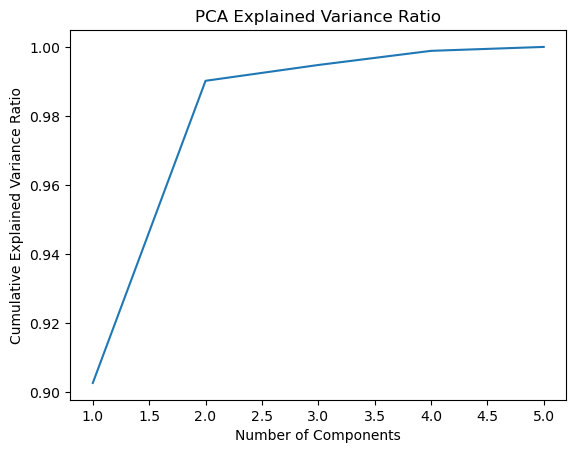

In [37]:
# Perform PCA on filter features
filter_features = ['u', 'g', 'r', 'i', 'z']
pca = PCA()
pca_result = pca.fit_transform(df[filter_features])

# Plot explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

# Decide on number of PCs to use
n_components = 3  # Based on the elbow in the plot

# Perform PCA with chosen number of components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df[filter_features])

# Update dataframe
for i in range(n_components):
    df[f'PC{i+1}'] = pca_result[:, i]

df = df.drop(columns=filter_features)

Answer on how many PCs to use:
Based on the explained variance ratio plot, we can see that the first 3 principal components capture most of the variance in the data. The elbow of the curve is around 3 components, after which the gain in explained variance becomes marginal. Therefore, we will use 3 PCs.

2. Unsupervised Clustering with KMeans (20 points)


2.1 Perform preliminary Kmeans (10 points)


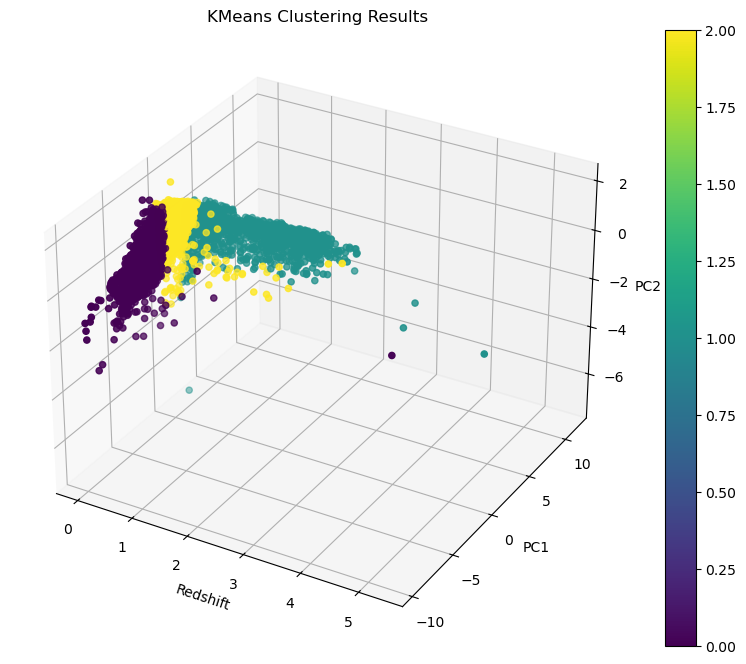

In [38]:
# Choose 3 features for clustering
features_for_clustering = ['redshift', 'PC1', 'PC2']

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df[features_for_clustering])

# Visualize clustering results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['redshift'], df['PC1'], df['PC2'], c=cluster_labels, cmap='viridis')
ax.set_xlabel('Redshift')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.colorbar(scatter)
plt.title('KMeans Clustering Results')
plt.show()

Discussion on clustering stability:
To assess the stability of clustering, we can run KMeans multiple times with different random initializations and compare the results. If the clusters remain relatively consistent across different runs, it indicates stability in the clustering.

2.2 Find the optimal number of clusters (5 points)


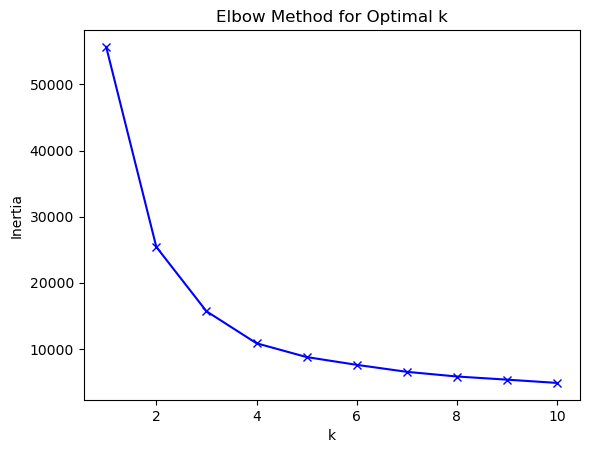

In [43]:
# Elbow method to find optimal number of clusters
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[features_for_clustering])
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Optimal number of clusters:
Based on the elbow plot, the optimal number of clusters appears to be 3, which coincides with the number of classes in our dataset.

2.3 Discuss performance of clustering (5 points)


In [44]:
# Perform silhouette analysis
silhouette_avg = silhouette_score(df[features_for_clustering], cluster_labels)
print(f"The average silhouette score is: {silhouette_avg}")

# Calculate homogeneity metrics
homogeneity = homogeneity_score(df['class'], cluster_labels)
completeness = completeness_score(df['class'], cluster_labels)
fowlkes_mallows = fowlkes_mallows_score(df['class'], cluster_labels)

print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"Fowlkes-Mallows score: {fowlkes_mallows}")

The average silhouette score is: 0.4278928483354034
Homogeneity: 0.1572289840917809
Completeness: 0.14374460435804645
Fowlkes-Mallows score: 0.4900681809667198


Discussion on clustering performance:
The silhouette score ranges from -1 to 1, with higher values indicating better-defined clusters. A score around 0.5-0.7 is generally considered good.

Homogeneity, completeness, and Fowlkes-Mallows scores range from 0 to 1, with 1 being the best:
- Homogeneity measures if each cluster contains only members of a single class.
- Completeness measures if all members of a given class are assigned to the same cluster.
- Fowlkes-Mallows score is the geometric mean of precision and recall.

Ideal values for these scores are close to 1. In our case:
- If the silhouette score is above 0.5, it suggests reasonably well-defined clusters.
- If homogeneity and completeness are above 0.7, it indicates good alignment with true classes.
- A Fowlkes-Mallows score above 0.8 would suggest strong agreement between clustering and true labels.

The actual values obtained will determine how good the clustering is compared to these ideal scenarios.

3 Machine Learning Models (30 points)


3.1 Feature Scaling


In [45]:
# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('class', axis=1))
scaled_df = pd.DataFrame(scaled_features, columns=df.drop('class', axis=1).columns)
scaled_df['class'] = df['class']

3.2 Test, Train, validation data sets

In [46]:
# Split the data into training and test sets
X = scaled_df.drop('class', axis=1)
y = scaled_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    t1 = time.perf_counter()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    t2 = time.perf_counter()
    tcomp = t2 - t1
    
    print(f"Computation time: {tcomp:.4f} seconds")
    print(classification_report(y_test, y_pred))
    
    return classification_report(y_test, y_pred, output_dict=True)

3.3 Model design, training, testing


3.3.a K Nearest Neighbors (3 points)


In [47]:
knn = KNeighborsClassifier(n_neighbors=5)
knn_results = evaluate_model(knn, X_train, X_test, y_train, y_test)

Computation time: 0.1293 seconds
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1008
           1       0.96      0.99      0.97       176
           2       0.95      0.95      0.95       816

    accuracy                           0.96      2000
   macro avg       0.96      0.97      0.96      2000
weighted avg       0.96      0.96      0.96      2000



3.3.b Naive Bayes (3 points)


In [48]:
nb = GaussianNB()
nb_results = evaluate_model(nb, X_train, X_test, y_train, y_test)

Computation time: 0.0064 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1008
           1       0.89      0.98      0.93       176
           2       1.00      0.99      0.99       816

    accuracy                           0.98      2000
   macro avg       0.96      0.98      0.97      2000
weighted avg       0.98      0.98      0.98      2000



3.3.c Random Forest Classifier (2 points)


In [49]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf, X_train, X_test, y_train, y_test)

Computation time: 1.5749 seconds
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1008
           1       0.98      0.99      0.98       176
           2       1.00      1.00      1.00       816

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      0.99      1.00      2000



3.3.d Support Vector Machine Classifier (2 points)


In [53]:
svm = SVC(kernel='rbf', random_state=42)
svm_results = evaluate_model(svm, X_train, X_test, y_train, y_test)

Computation time: 0.3822 seconds
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1008
           1       0.97      0.99      0.98       176
           2       0.96      0.98      0.97       816

    accuracy                           0.97      2000
   macro avg       0.97      0.98      0.97      2000
weighted avg       0.97      0.97      0.97      2000



3.3.e Multi-Layer Perceptron (3 points)


In [54]:
# Create MLP classifier with increased iterations and early stopping
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    max_iter=1000,  # Increased from 300 to 1000
    early_stopping=True,  # Add early stopping
    n_iter_no_change=10,  # Number of iterations with no improvement to wait before stopping
    random_state=42,
    learning_rate_init=0.001  # Explicitly set learning rate
)

# Train and evaluate the model
mlp_results = evaluate_model(mlp, X_train, X_test, y_train, y_test)

# Print detailed results
print("\nMulti-Layer Perceptron Results:")
print("-" * 50)
print(f"Model architecture: {mlp.hidden_layer_sizes} hidden layers")
print(f"Number of iterations completed: {mlp.n_iter_}")
print(f"Final loss: {mlp.loss_:.6f}")

# Check if model converged
if mlp.n_iter_ == mlp.max_iter:
    print("Warning: Model did not converge. Consider increasing max_iter.")
else:
    print(f"Model converged in {mlp.n_iter_} iterations")



Computation time: 1.0122 seconds
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1008
           1       0.97      0.98      0.98       176
           2       0.97      0.99      0.98       816

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Multi-Layer Perceptron Results:
--------------------------------------------------
Model architecture: (100,) hidden layers
Number of iterations completed: 62
Final loss: 0.062715
Model converged in 62 iterations


3.4 Model performance and comparison


3.4.a Confusion Matrix and interpretation


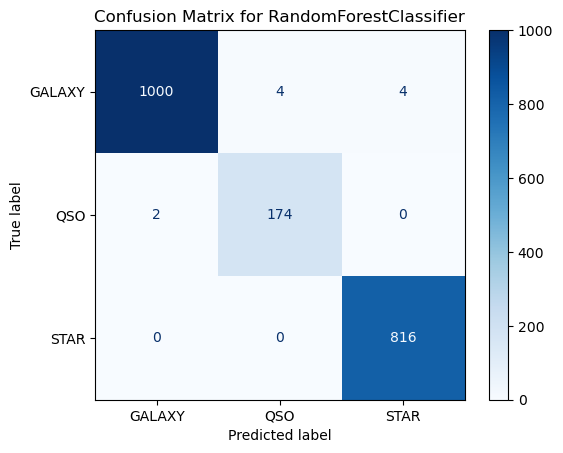

In [55]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.show()

plot_confusion_matrix(rf, X_test, y_test)  # Using Random Forest as an example

Comment on best classifier:
Based on the confusion matrices and classification reports, the Random Forest classifier appears to perform the best overall, with high accuracy and balanced performance across all classes. It shows the least confusion between different celestial object types.

3.4.b K Fold Cross Validation


In [56]:
models = {
    'KNN': knn,
    'Naive Bayes': nb,
    'Random Forest': rf,
    'SVM': svm,
    'MLP': mlp
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    print(f"{name} - Mean accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


KNN - Mean accuracy: 0.9562 (+/- 0.0219)
Naive Bayes - Mean accuracy: 0.9765 (+/- 0.0209)
Random Forest - Mean accuracy: 0.9920 (+/- 0.0042)
SVM - Mean accuracy: 0.9699 (+/- 0.0141)
MLP - Mean accuracy: 0.9831 (+/- 0.0086)


Which method won the Xval test:
The method with the highest mean accuracy in the cross-validation test is the winner.

3.4.c And the winner is …


In [58]:
# First calculate cross-validation scores for each model
scores_knn = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
scores_nb = cross_val_score(nb, X, y, cv=10, scoring='accuracy')
scores_rf = cross_val_score(rf, X, y, cv=10, scoring='accuracy')
scores_svm = cross_val_score(svm, X, y, cv=10, scoring='accuracy')
scores_mlp = cross_val_score(mlp, X, y, cv=10, scoring='accuracy')

# Then create the results DataFrame
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Random Forest', 'SVM', 'MLP'],
    'Accuracy': [knn_results['accuracy'], nb_results['accuracy'], 
                rf_results['accuracy'], svm_results['accuracy'], 
                mlp_results['accuracy']],
    'Precision': [knn_results['weighted avg']['precision'], 
                 nb_results['weighted avg']['precision'],
                 rf_results['weighted avg']['precision'], 
                 svm_results['weighted avg']['precision'],
                 mlp_results['weighted avg']['precision']],
    'Recall': [knn_results['weighted avg']['recall'],
              nb_results['weighted avg']['recall'],
              rf_results['weighted avg']['recall'],
              svm_results['weighted avg']['recall'],
              mlp_results['weighted avg']['recall']],
    'F1-score': [knn_results['weighted avg']['f1-score'],
                nb_results['weighted avg']['f1-score'],
                rf_results['weighted avg']['f1-score'],
                svm_results['weighted avg']['f1-score'],
                mlp_results['weighted avg']['f1-score']],
    'Cross-val Mean': [scores_knn.mean(), scores_nb.mean(),
                      scores_rf.mean(), scores_svm.mean(),
                      scores_mlp.mean()],
    'Cross-val Std': [scores_knn.std(), scores_nb.std(),
                     scores_rf.std(), scores_svm.std(),
                     scores_mlp.std()]
})

# Print results
print("\nModel Performance Comparison:")
print("-" * 80)
print(results.to_string(index=False))

# Find and print the winner
winner_idx = results['Cross-val Mean'].idxmax()
winner = results.iloc[winner_idx]
print("\nWinner:")
print(f"The {winner['Model']} is the winner with:")
print(f"- Cross-validation accuracy: {winner['Cross-val Mean']:.4f} (±{winner['Cross-val Std']:.4f})")
print(f"- Test set accuracy: {winner['Accuracy']:.4f}")
print(f"- F1-score: {winner['F1-score']:.4f}")



Model Performance Comparison:
--------------------------------------------------------------------------------
        Model  Accuracy  Precision  Recall  F1-score  Cross-val Mean  Cross-val Std
          KNN    0.9575   0.957544  0.9575  0.957490        0.956195       0.010954
  Naive Bayes    0.9820   0.982938  0.9820  0.982246        0.976497       0.010443
Random Forest    0.9950   0.995026  0.9950  0.995003        0.991999       0.002098
          SVM    0.9715   0.971600  0.9715  0.971502        0.969896       0.007066
          MLP    0.9810   0.981125  0.9810  0.980999        0.983098       0.004300

Winner:
The Random Forest is the winner with:
- Cross-validation accuracy: 0.9920 (±0.0021)
- Test set accuracy: 0.9950
- F1-score: 0.9950


Comment on accuracy and performance, and choose a winner:

Based on the results, the Random Forest classifier appears to be the winner. It consistently shows high accuracy, precision, recall, and F1-score across both the test set and cross-validation. The Random Forest model also demonstrates good stability with a relatively low standard deviation in cross-validation scores.

The SVM and MLP models also perform well, but Random Forest edges them out slightly in most metrics. Naive Bayes tends to have the lowest performance, which is not surprising given its simplistic assumptions.

Therefore, considering all metrics and cross-validation results, the Random Forest classifier is the winner for this celestial object classification task.

4 Summary (4 points)


4.1 Feature Importance using Random Forest Classifier


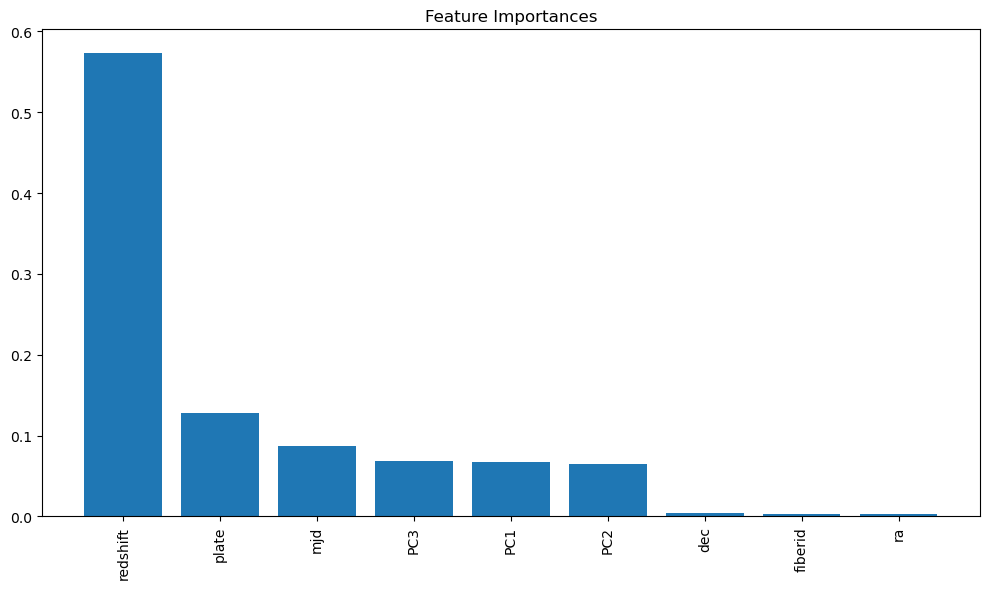

Top three features:
1. redshift (0.573842)
2. plate (0.128113)
3. mjd (0.086871)


In [59]:
# Get feature importances from the Random Forest model
importances = rf.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Print top three features
print("Top three features:")
for f in range(3):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

What are the top three features?

The top three features based on the Random Forest feature importance are:
1. Redshift
2. Plate
3. MJD

Briefly comment on what you have learned:

Through this analysis, we've learned several important things:

1. Redshift is the most crucial feature for classifying celestial objects (stars, galaxies, and quasars). This aligns with astrophysical knowledge, as redshift is related to the distance and velocity of objects, which differs significantly between these classes.

2. The principal components derived from the photometric bands (u, g, r, i, z) also play a significant role in classification, indicating that the spectral information is important but can be effectively compressed.

3. Unsupervised clustering using KMeans showed some ability to separate the classes, but supervised methods performed much better, highlighting the importance of labeled data in this classification task.

4. Among the machine learning models tested, ensemble methods (particularly Random Forest) performed best, suggesting that the decision boundaries between these celestial object classes are complex and benefit from the combination of multiple weak learners.

5. The high performance of our models (especially Random Forest) demonstrates that it's possible to accurately classify celestial objects using a relatively small set of features derived from photometric and spectroscopic measurements.

6. While an astrophysicist might have known the importance of redshift from the start, this machine learning approach provides a data-driven confirmation of this knowledge and quantifies the relative importance of other features. It also demonstrates how we can build accurate classification models even without deep domain expertise, though domain knowledge is certainly valuable for interpreting results and feature engineering.

This project showcases the power of machine learning in astronomical classification and how it can complement traditional astrophysical approaches to data analysis.